![alt text](https://i0.wp.com/articolidiastronomia.com/wp-content/uploads/2021/01/cropped-cropped-icona-21-2.jpeg?w=1600&ssl=1)

In [215]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [216]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from skyfield.api import Star, load
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
from skyfield.data import hipparcos, mpc, stellarium
from skyfield.projections import build_stereographic_projection

import folium
from folium import plugins
from folium.plugins import HeatMap
import os
import geopy
import json

from datetime import date
import datetime

from colorama import Fore
from colorama import Style

import datetime, io, skyfield.api, skyfield.constants, skyfield.data.mpc
import geocoder
import io
import re

## Input information

Select the **location**

In [217]:
location = 'Villasanta Via Bestetti, Italy'
label='GAV Gruppo Astrofili Villasanta'

Select **starting date of analysis**

In [218]:
date_min = '2021-02-10'

## Start analysis

Retrieve the geo coordinates

In [219]:
latitude, longitude = geocoder.arcgis(location).latlng    

In [220]:
map_world = folium.Map(location=[latitude, longitude], titles = 'Stamen Terrain', zoom_start=15)
folium.CircleMarker(
    [latitude, longitude],
    radius=7,
    popup=label,
    fill=True,
    color='Red',
    fill_color='Blue',
    fill_opacity=0.9
    ).add_to(map_world)

map_world

In [221]:
today = date.today()
date_max = today.strftime("%Y-%m-%d")

**Recap of the input data**

In [222]:
date_min_obj = datetime.datetime.strptime(date_min, '%Y-%m-%d')
date_max_obj = datetime.datetime.strptime(date_max, '%Y-%m-%d')

delta = date_max_obj - date_min_obj

print (f'Period of analysis: {Fore.MAGENTA} [%s, %s] {Style.RESET_ALL}' % (str(date_min), str(date_max)))
print (f'Total days: {Fore.MAGENTA} %2d {Style.RESET_ALL}' % (delta.days))
print (f'Observation point: {Fore.MAGENTA} [%f, %f] {Style.RESET_ALL}' % (latitude, longitude))

Period of analysis:  [2021-02-10, 2021-02-24] 
Total days:  14 
Observation point:  [45.603195, 9.300567] 


In [223]:
ts = load.timescale()
t_comet = ts.utc(date_min_obj.year, date_min_obj.month, range(delta.days)) 

Load Solar System Dynamics file from JPL for Guidance, Navigation, and Control section. See following links: 

* https://naif.jpl.nasa.gov/pub/naif/JUNO/kernels/spk/de421.bsp.lbl 
* https://naif.jpl.nasa.gov/pub/naif/JUNO/kernels/spk/

In [224]:
t = t_comet[len(t_comet) // 2]  # center the ts period

eph = load('de421.bsp')
sun = eph['sun']
earth = eph['earth']

### Get Eath close approach for some asteorids using NASA api

Get Earth close-approach data for NEOs within 5 lunar distances on or after 2021-Jan-01 sorted by distance

In [225]:
dist_max = '5LD'
import requests

payload = {'sort': 'date', 'date-min': date_min, 'date-max': date_max, 'dist-max': dist_max}
r = requests.get("https://ssd-api.jpl.nasa.gov/cad.api", params=payload)
print('Url format:',r.url)

Url format: https://ssd-api.jpl.nasa.gov/cad.api?sort=date&date-min=2021-02-10&date-max=2021-02-24&dist-max=5LD


Get response from NASA api via JSON format

In [226]:
ans = r.json()
ans

{'signature': {'source': 'NASA/JPL SBDB Close Approach Data API',
  'version': '1.1'},
 'count': '24',
 'fields': ['des',
  'orbit_id',
  'jd',
  'cd',
  'dist',
  'dist_min',
  'dist_max',
  'v_rel',
  'v_inf',
  't_sigma_f',
  'h'],
 'data': [['2021 CX',
   '3',
   '2459255.805022952',
   '2021-Feb-10 07:19',
   '0.0127700936861324',
   '0.0127026038432749',
   '0.0128375797501716',
   '8.89556933831153',
   '8.87208284248406',
   '< 00:01',
   '27.983'],
  ['2021 CU1',
   '3',
   '2459256.681232345',
   '2021-Feb-11 04:21',
   '0.00404823498658235',
   '0.0040400570388589',
   '0.00405641232150679',
   '8.40931843849374',
   '8.33068248432238',
   '< 00:01',
   '28.581'],
  ['2021 CU6',
   '4',
   '2459256.926448669',
   '2021-Feb-11 10:14',
   '0.00848812403504478',
   '0.00847505940364819',
   '0.00850118854975646',
   '14.6604383930772',
   '14.6390109091714',
   '< 00:01',
   '26.778'],
  ['2021 DJ1',
   '2',
   '2459257.024366627',
   '2021-Feb-11 12:35',
   '0.0064037777028870

In [227]:
# get amount of NEOs
count = ans['count']
print('NASA API retrieved ', count, ' object (NEO or asteorids) items according to the submit time-interval request')

NASA API retrieved  24  object (NEO or asteorids) items according to the submit time-interval request


In [228]:
import pandas as pd 
#convert to DataFrame
df = pd.DataFrame.from_dict(ans['data'])
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,2021 CX,3,2459255.805022952,2021-Feb-10 07:19,0.0127700936861324,0.0127026038432749,0.0128375797501716,8.89556933831153,8.87208284248406,< 00:01,27.983
1,2021 CU1,3,2459256.681232345,2021-Feb-11 04:21,0.00404823498658235,0.0040400570388589,0.00405641232150679,8.40931843849374,8.33068248432238,< 00:01,28.581
2,2021 CU6,4,2459256.926448669,2021-Feb-11 10:14,0.00848812403504478,0.00847505940364819,0.00850118854975646,14.6604383930772,14.6390109091714,< 00:01,26.778
3,2021 DJ1,2,2459257.024366627,2021-Feb-11 12:35,0.00640377770288704,0.00635530373078403,0.00645223854463776,6.01851633453269,5.94898144819872,00:21,27.623
4,2021 CO,6,2459257.140025835,2021-Feb-11 15:22,0.00241997649071446,0.00241657125210385,0.00242338157455646,11.5696486264115,11.4740881514418,< 00:01,25.256


Convert Dataframe column from  object into proper type

In [229]:
df.columns = ans['fields']
df.dtypes

des          object
orbit_id     object
jd           object
cd           object
dist         object
dist_min     object
dist_max     object
v_rel        object
v_inf        object
t_sigma_f    object
h            object
dtype: object

In [230]:
#convert to float

df['dist_min'] = df['dist_min'].astype(float)
df['dist_max'] = df['dist_max'].astype(float)
df['dist'] = df['dist'].astype(float)
df['jd'] = df['jd'].astype(float)
df['v_rel'] = df['v_rel'].astype(float)
df['v_inf'] = df['v_inf'].astype(float)
df['h'] = df['h'].astype(float)

Drop useless columns for this analysis l ike Julian date, sigma interval, inifite velocity and orbit id of the objects

In [231]:
new_df = df.drop(columns=['jd', 'orbit_id','v_inf','t_sigma_f'], axis=1)

Assign a proper name to each column in order to be human readable

In [232]:
col = []
col.append('Designation')
col.append('Calendar_close_approach') # calendar
col.append('approach_distance') # nominal approach distance (au) will past to our planet
col.append('dist_min') # minimum (3-sigma) approach distance (au) can possible came during flyby
col.append('dist_max') # maximum (3-sigma) approach distance (au)
col.append('rel_velocity') # velocity relative to the approach body at close approach (Km/s)
#col.append('v_inf') # velocity relative to a massless body (km/s)
#col.append('t_sigma_f') # 3-sigma uncertainty in the time of close-approac (ddhhmm)
col.append('magnitude') # absolute magnitude (mag)

new_df.columns = col

new_df.reset_index(drop=True, inplace=True)
new_df.head()

,Designation,Calendar_close_approach,approach_distance,dist_min,dist_max,rel_velocity,magnitude
0,2021 CX,2021-Feb-10 07:19,0.012770,0.012703,0.012838,8.895569,27.983
1,2021 CU1,2021-Feb-11 04:21,0.004048,0.004040,0.004056,8.409318,28.581
2,2021 CU6,2021-Feb-11 10:14,0.008488,0.008475,0.008501,14.660438,26.778
3,2021 DJ1,2021-Feb-11 12:35,0.006404,0.006355,0.006452,6.018516,27.623
4,2021 CO,2021-Feb-11 15:22,0.002420,0.002417,0.002423,11.569649,25.256


For detail regarding the column meaning https://cneos.jpl.nasa.gov/ca/neo_ca_tutorial.html

Main statistical parameters regarding the approach distance of objects in Km

In [233]:
new_df['approach_distance_km'] = new_df['approach_distance'] * 14960000
new_df['approach_distance_km'].describe()

count        24.000000
mean      84451.134425
std       65117.941484
min        2803.139314
25%       19205.805813
50%       78181.054917
75%      133348.369909
max      191040.601545
Name: approach_distance_km, dtype: float64

Get the info about the nearest object approach to the Earth in the date interval specified

In [234]:
min_object = new_df['approach_distance'].min()
new_min_df = new_df[new_df['approach_distance'] == min_object]
new_min_df.reset_index(drop=True, inplace=True)
new_min_df

,Designation,Calendar_close_approach,approach_distance,dist_min,dist_max,rel_velocity,magnitude,approach_distance_km
0,2021 CW7,2021-Feb-14 16:14,0.000187,0.000187,0.000187,9.561812,31.207,2803.139314


See below video for a full description of each fields

[![IMAGE ALT TEXT HERE](https://img.youtube.com/vi/UA6voCyCW1g/0.jpg)](https://www.youtube.com/watch?v=UA6voCyCW1g)


In [235]:
designation = new_min_df['Designation']
dist_min = new_min_df['dist_min']
dist_min_km = dist_min * 149600000

calendar_close_approach = new_min_df['Calendar_close_approach']
relative_velocity =  new_min_df['rel_velocity']
magnitude = new_min_df['magnitude']
print(f'The nearest object to the Earth with minimum approach distance is: {designation.item()}')
print (f'Minimum distance from Earth will be: {dist_min.item()} ua or {dist_min_km.item()} Km')
print (f'Approach calendar time: {calendar_close_approach.item()}')
print (f'Relative velocity to Earth: {relative_velocity.item()} Km/s')
print (f'Absolute magnitude: {magnitude.item()}')

The nearest object to the Earth with minimum approach distance is: 2021 CW7
Minimum distance from Earth will be: 0.000187273865570025 ua or 28016.170289275742 Km
Approach calendar time: 2021-Feb-14 16:14
Relative velocity to Earth: 9.56181210191102 Km/s
Absolute magnitude: 31.207


## Get detail info from MPC

Format of the response by  MPC: https://minorplanetcenter.net//iau/info/MPOrbitFormat.html

In [236]:
def load_mpcorb_dataframe(fobj):
    #fobj = io.StringIO(fobj)
    columns = mpc._MPCORB_COLUMNS
    names, colspecs = zip(*columns)
    df = pd.read_fwf(fobj, colspecs, names=names, dtypes=mpc._MPCORB_DTYPES, converters=mpc._MPCORB_CONVERTERS, skiprows=43)
    return df

In [237]:
MPCORB_URL_PLAIN = 'https://www.minorplanetcenter.net/iau/MPCORB/MPCORB.DAT'

In [238]:
from skyfield.api import Star, load
from skyfield.data import hipparcos, mpc, stellarium

with load.open(MPCORB_URL_PLAIN) as f:
    body_mpc = load_mpcorb_dataframe(f)

body_mpc = (body_mpc.sort_values('reference').groupby('designation', as_index=False).last().set_index('designation', drop=False))

body_mpc.head()

,designation,designation_packed,magnitude_H,magnitude_G,epoch_packed,mean_anomaly_degrees,argument_of_perihelion_degrees,longitude_of_ascending_node_degrees,inclination_degrees,eccentricity,...,reference,observations,oppositions,observation_period,rms_residual_arcseconds,coarse_perturbers,precise_perturbers,computer_name,hex_flags,last_observation_date
designation,,,,,,,,,,,,,,,,,,,,,
(1) Ceres,(1) Ceres,00001,3.53,0.15,K20CH,205.54543,73.72487,80.27236,10.58790,0.078168,...,E2021-B10,7277.0,118.0,1801-2020,0.51,M-v,30k,Pan,0000,20201118.0
(10) Hygiea,(10) Hygiea,00010,5.53,0.15,K20CH,258.20934,312.42104,283.19813,3.83148,0.111947,...,E2021-B10,3530.0,94.0,1849-2020,0.59,M-v,3Ek,Pan,0000,20201111.0
(100) Hekate,(100) Hekate,00100,7.65,0.15,K20CH,355.77222,184.16326,127.17566,6.43332,0.169846,...,E2021-B10,3004.0,81.0,1871-2020,0.49,M-v,3Ek,Pan,0000,20201110.0
(1000) Piazzia,(1000) Piazzia,01000,10.71,0.15,K20CH,92.88911,280.66063,323.70620,20.58830,0.258554,...,E2021-B10,3902.0,37.0,1923-2021,0.62,M-v,3Ek,Pan,0000,20210112.0
(10000) Myriostos,(10000) Myriostos,10000,15.16,0.15,K20CH,233.74271,200.26459,169.50344,20.64615,0.306142,...,E2021-B10,591.0,26.0,1951-2020,0.60,M-v,3Ek,Pan,0000,20200422.0


Show the **orbital parameters** of the target object

In [239]:
row = body_mpc [body_mpc['designation'] == new_min_df['Designation'].item()]
row

,designation,designation_packed,magnitude_H,magnitude_G,epoch_packed,mean_anomaly_degrees,argument_of_perihelion_degrees,longitude_of_ascending_node_degrees,inclination_degrees,eccentricity,...,reference,observations,oppositions,observation_period,rms_residual_arcseconds,coarse_perturbers,precise_perturbers,computer_name,hex_flags,last_observation_date
designation,,,,,,,,,,,,,,,,,,,,,
2021 CW7,2021 CW7,K21C07W,31.22,0.15,K20CH,276.76165,245.30194,326.53301,1.17229,0.287165,...,E2021-CX0,32.0,1.0,2 days,0.66,M-v,3Ek,Veres,0803,20210214.0


* From **Hipparcos catalog** retrieves star catalog
* From **Stellarium** retrieves the Wester constellation culture

In [240]:
body_mpc = body_mpc.drop(columns=['designation_packed'], axis=1)
row = body_mpc.loc[new_min_df['Designation'].item()]
row

designation                               2021 CW7
magnitude_H                                  31.22
magnitude_G                                   0.15
epoch_packed                                 K20CH
mean_anomaly_degrees                       276.762
argument_of_perihelion_degrees             245.302
longitude_of_ascending_node_degrees        326.533
inclination_degrees                        1.17229
eccentricity                              0.287165
mean_daily_motion_degrees                 0.747225
semimajor_axis_au                          1.20273
uncertainty                                      5
reference                                E2021-CX0
observations                                    32
oppositions                                      1
observation_period                          2 days
rms_residual_arcseconds                       0.66
coarse_perturbers                              M-v
precise_perturbers                             3Ek
computer_name                  

In [241]:
comet = sun + mpc.mpcorb_orbit(row, ts, GM_SUN)

with load.open(hipparcos.URL) as f:
    stars = hipparcos.load_dataframe(f)

url = ('https://raw.githubusercontent.com/Stellarium/stellarium/master/skycultures/western_SnT/constellationship.fab')

with load.open(url) as f:
    constellations = stellarium.parse_constellations(f)

edges = [edge for name, edges in constellations for edge in edges]
edges_star1 = [star1 for star1, star2 in edges]
edges_star2 = [star2 for star1, star2 in edges]

Center the chart on middle orbit of the target body

In [242]:
center = earth.at(t).observe(comet)
projection = build_stereographic_projection(center)

Set the field view and th max star magnitude in term of **field size** and **max star magnitude** 

In [284]:
field_of_view_degrees = 30.0
limiting_magnitude = 7.0

Draw the star chart with body trajectory

Text(0.5, 1.0, ' 2021 CW7 trajectory from [2021 January 31] to [2021 February 13]')

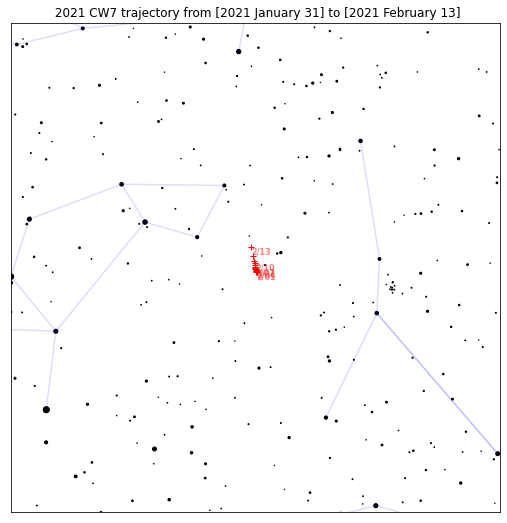

In [286]:
star_positions = earth.at(t).observe(Star.from_dataframe(stars))
stars['x'], stars['y'] = projection(star_positions)

comet_x, comet_y = projection(earth.at(t_comet).observe(comet))

bright_stars = (stars.magnitude <= limiting_magnitude)
magnitude = stars['magnitude'][bright_stars]
marker_size = (0.5 + limiting_magnitude - magnitude) ** 2.0

xy1 = stars[['x', 'y']].loc[edges_star1].values
xy2 = stars[['x', 'y']].loc[edges_star2].values
lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)

fig, ax = plt.subplots(figsize=[9, 9])

# Draw the constellation lines.

ax.add_collection(LineCollection(lines_xy, colors='#00f2'))
ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
           s=marker_size, color='k')

# Draw the comet positions, and label them with dates.

comet_color = '#f00'
offset = 0.0002

ax.plot(comet_x, comet_y, '+', c=comet_color, zorder=3)

step = 1
for xi, yi, tstr in zip(comet_x, comet_y, t_comet.utc_strftime('%m/%d')):
    step = step + 1
    tstr = tstr.lstrip('0')
    if ((step % 3) == 0):
        text = ax.text(xi + offset, yi - offset, tstr, color=comet_color,
                       ha='left', va='top', fontsize=8, weight='bold', zorder=-1)
    text.set_alpha(0.5)

# title
angle = np.pi - field_of_view_degrees / 360.0 * np.pi
limit = np.sin(angle) / (1.0 - np.cos(angle))

ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_aspect(1.0)
ax.set_title(' {} trajectory from [{}] to [{}]'.format(
    new_min_df['Designation'].item(),
    t_comet[0].utc_strftime('%Y %B %d'),
    t_comet[-1].utc_strftime('%Y %B %d'),
))
